# Street View Image Metadata

The Street View API metadata requests provide data about Street View panoramas. Using the metadata, you can find out if a Street View image is available at a given location.

Street View API metadata requests are free to use. **No quota is consumed** when you request metadata. Quota is only consumed when you load an image using the Street View API.

In [55]:
import os, math
import json
import overpass
import pandas as pd
import numpy as np
from tqdm import tqdm
from urllib.request import urlopen, HTTPError
from gsvloader import polygon_to_points, loader
from shapely.geometry import Polygon, Point, LineString, MultiLineString
from copy import deepcopy

keys = pd.read_csv('api-keys.csv', header=None)

## Check Geojson properties

In [2]:
with open(os.path.join('data','shapefiles','นครศรีธรรมราช.geojson')) as f:
    data = json.load(f)

## Sample Subdistrict

In [3]:
geojson_prop = {
    'PV_TN': 'นครศรีธรรมราช',
    'AP_TN': 'เมืองนครศรีธรรมราช',
    'TB_TN': 'คลัง'
}

entry = {
    'GEOJSON_PATH': os.path.join('data','shapefiles','นครศรีธรรมราช.geojson'),
    'keys': np.squeeze(keys.values)
}

### Get polygon of the area

['นครศรีธรรมราช', 'คลัง', 'เมืองนครศรีธรรมราช']


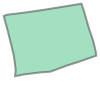

In [42]:
polygon = polygon_to_points.get_polygon(entry, geojson_prop)
polygon

### Get linestring of roads

In [103]:
roads = polygon_to_points.generate_overpass_script(polygon)

with open(os.path.join('data', 'v2', 'linestrings.geojson'), 'w') as FILE:
    json.dump(roads, FILE, indent=4)

### Extract coordinates along roads/streets

In [74]:
def linestring_to_coords(roads):
    point_entry = {
        "type": "FeatureCollection",
        "features": []
    }
    for road in tqdm(roads['features'],'converting linestrings to coordinates'):
        if (road['geometry']['type'] != 'LineString'):
            continue
        
        line = deepcopy(road['geometry']['coordinates'])
        road['geometry']['coordinates'] = []
        
        for i in range(len(line)-1):
            x1,y1 = line[i]
            x2,y2 = line[i+1]
            x1 += 0.0000000001

            degree = math.degrees(math.atan(abs((y1-y2)/(x1-x2))))

            if(degree < 45): 
                if(x1 == min(x1,x2)): start_x,start_y, end_x,end_y = x1,y1, x2,y2 
                else: start_x,start_y, end_x,end_y = x2,y2, x1,y1

                m = (start_y-end_y)/(start_x-end_x)
                FROM, TO = start_x, end_x                      
                cur_x, cur_y = start_x, start_y
                while(FROM < TO):
                    new_x, new_y = linearEquation_x(start_x, start_y, m, FROM)
                    dist = math.hypot(new_x-cur_x, new_y-cur_y)
                    meters = 111111*dist
                    if(meters > 50):
                        cur_x, cur_y = new_x, new_y
                        road['geometry']['coordinates'].append([round(cur_x, 8), round(cur_y, 8)])  
                    FROM += 0.000000123
            else:
                if(y1 == min(y1,y2)): start_x,start_y, end_x,end_y = x1,y1, x2,y2 
                else: start_x,start_y, end_x,end_y = x2,y2, x1,y1

                m = (start_y-end_y)/(start_x-end_x)
                FROM, TO = start_y, end_y                      
                cur_x, cur_y = start_x, start_y
                while(FROM < TO):
                    new_x, new_y = linearEquation_y(start_x, start_y, m, FROM)
                    dist = math.hypot(new_x-cur_x, new_y-cur_y)
                    meters = 111111*dist
                    if(meters > 50):
                        cur_x, cur_y = new_x, new_y
                        road['geometry']['coordinates'].append([round(cur_x, 8), round(cur_y, 8)])  
                    FROM += 0.000000123
        point_entry['features'].append(road)
    return point_entry

def linearEquation_x(x1, y1, m, x):
    y = m*(x-x1)+y1
    return x,y

def linearEquation_y(x1, y1, m, y):
    x = (y - y1 + (m*x1)) / m
    return x,y

In [76]:
point_geojson = linestring_to_coords(roads)

with open(os.path.join('data', 'v2', 'points-on-linestrings.geojson'), 'w') as FILE:
    json.dump(point_geojson, FILE, indent=4)

converting linestrings to coordinates: 100%|██████████| 105/105 [00:02<00:00, 46.29it/s]


### Send requests if a Street View image is available at a given location.

In [96]:
no_missing = []
missing_streets = deepcopy(point_geojson)
for i, feature in enumerate(tqdm(point_geojson['features'], 'loading GSV')):
    
    has_missing = False
    missing_streets['features'][i]['geometry']['coordinates'] = []

    for lng, lat in feature['geometry']['coordinates']:
        requestMeta = urlopen(
            "https://maps.googleapis.com/maps/api/streetview/metadata?"+\
            "location="+str(lat)+','+str(lng)+"&key="+entry['keys'][0]
        )    
        metaJson = json.loads(requestMeta.read().decode('utf8'))
        if metaJson["status"] != 'OK':
            missing_streets['features'][i]['geometry']['coordinates'].append([lng, lat])
            has_missing = True
            
    if not has_missing: no_missing.append(i)

loading GSV: 100%|██████████| 105/105 [00:55<00:00,  1.90it/s]


In [100]:
for i in sorted(no_missing, reverse=True):
    del missing_streets['features'][i]

In [102]:
with open(os.path.join('data', 'v2', 'missing-streets.geojson'), 'w') as FILE:
    json.dump(missing_streets, FILE, indent=4)

### Example of metadata
* street view available
```json
{"copyright": "© Google, Inc.",
 "date": "2016-06",
 "location": {"lat": 8.601592312833652, "lng": 99.80298133747272},
 "pano_id": "u5Hn4GeNtMtk1EvLOa-N5w",
 "status": "OK"}
```
* street view *unavailable*
```json
{"status": "ZERO_RESULTS"}
```

Ref: https://developers.google.com/maps/documentation/streetview/metadata